In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/Materias2023/Redes/TP2/PhC-C2DH-U373.zip
!unzip /content/drive/MyDrive/PhC-C2DH-U373.zip

Archive:  /content/drive/MyDrive/PhC-C2DH-U373.zip
   creating: PhC-C2DH-U373/
   creating: PhC-C2DH-U373/01/
  inflating: PhC-C2DH-U373/01/t000.tif  
  inflating: PhC-C2DH-U373/01/t001.tif  
  inflating: PhC-C2DH-U373/01/t002.tif  
  inflating: PhC-C2DH-U373/01/t003.tif  
  inflating: PhC-C2DH-U373/01/t004.tif  
  inflating: PhC-C2DH-U373/01/t005.tif  
  inflating: PhC-C2DH-U373/01/t006.tif  
  inflating: PhC-C2DH-U373/01/t007.tif  
  inflating: PhC-C2DH-U373/01/t008.tif  
  inflating: PhC-C2DH-U373/01/t009.tif  
  inflating: PhC-C2DH-U373/01/t010.tif  
  inflating: PhC-C2DH-U373/01/t011.tif  
  inflating: PhC-C2DH-U373/01/t012.tif  
  inflating: PhC-C2DH-U373/01/t013.tif  
  inflating: PhC-C2DH-U373/01/t014.tif  
  inflating: PhC-C2DH-U373/01/t015.tif  
  inflating: PhC-C2DH-U373/01/t016.tif  
  inflating: PhC-C2DH-U373/01/t017.tif  
  inflating: PhC-C2DH-U373/01/t018.tif  
  inflating: PhC-C2DH-U373/01/t019.tif  
  inflating: PhC-C2DH-U373/01/t020.tif  
  inflating: PhC-C2DH-U373/01

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose
from tensorflow.keras.utils import plot_model

from PIL import Image

#Preprocesamiento y análisis de datos


##Carga de datos

In [ ]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [ ]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

In [ ]:
# Normalización
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)
val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

## EDA

In [ ]:
print(train_images.shape)
print(val_images.shape)

(115, 520, 696)
(115, 520, 696)


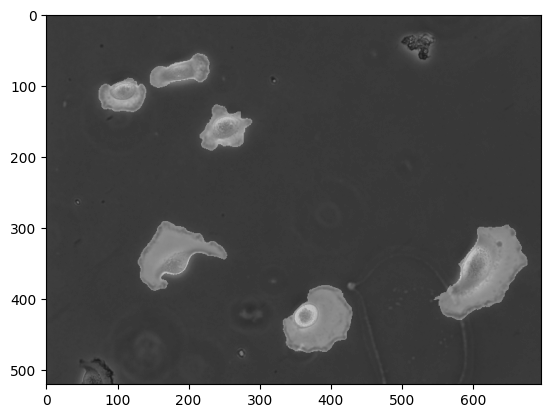

In [ ]:
# Analizo la imagen N°100
idx = 100
plt.imshow(train_images[idx], vmin=0, vmax=1, cmap="gray")
plt.imshow(train_masks[idx], vmin=0, vmax=1, cmap="gray",alpha=0.3)
plt.show()

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que se descompondrán durante el entrenamiento.

In [ ]:
x_train = np.stack((train_images, train_masks ),axis=-1)
x_val = np.stack((val_images, val_masks ),axis=-1)
len(x_val)

115

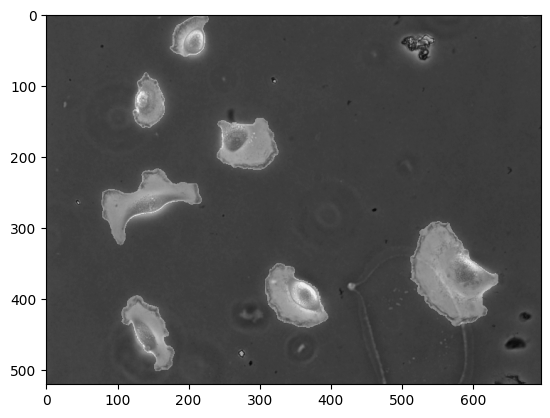

In [ ]:
plt.imshow(x_train[idx,:,:,0], cmap="gray")               # Img
plt.imshow(x_train[idx,:,:,1], cmap="gray", alpha = 0.3)  # Mask
plt.show()

## Data augmentation


In [ ]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        tf.keras.layers.RandomRotation(0.5)   # Puede rotar de -pi a pi
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

Se agregó rotación de la imagen entre $-\pi$ y $\pi$. Aplicar otro tipo de data augmentation empeoraba a la red, o simplmente no tenía sentido (ya que por ejemplo cambiaba el tamaño de la imagen, el cual debe ser fijo para la U-net)

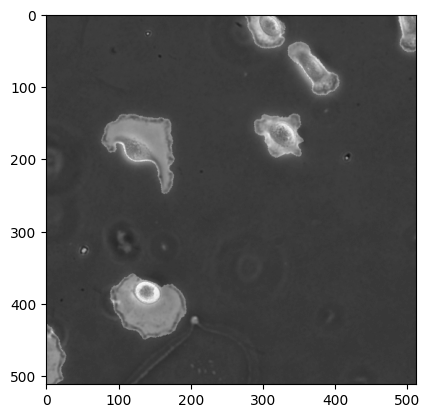

In [ ]:
preproc = get_preproc()
aux_elem = preproc(x_train[idx])
plt.imshow(aux_elem[:,:,0], cmap="gray")
plt.imshow(aux_elem[:,:,1], cmap="gray", alpha = 0.3)
plt.show()

# Coeficiente de dice

$dice_{coef}=\frac{2\cdot \cap}{\Sigma}$

Siendo $\cap$ la intersección de los conjuntos y $\Sigma$ la suma de los tamaños de los elementos de ambos conjuntos. El smooth esta para no dividir por cero.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#Red convolucional con Atrous Convolutions

La idea es que este sea un modelo simple para sentar las bases mínimas para la Unet

In [ ]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),   #None porque no hay flatten que necesite tamaño fijo
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


Con dilation_rate estoy haciendo un analisis en baja frecuencia de la imagen de entrada (como un upsampling). En vez de hacer max pooling vamos aumentando el dilation rate para aumentar el campo perceptual exponenciamente, sin aumentar el tamaño de salida respecto a la entrada.

También que se fueron aumentando el numero de filtros de las sucesivas capas, para un mejor resultado. Sin embargo el resultado obtenido no fue significativamente mejor al original. Por lo tanto debido a la escases de recursos y tiempo de ejecución, se optó por mantener el numero de filtros fijos.

In [ ]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val, dice):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice = dice

    def call(self, inputs):
        return self.red_segmentacion(inputs[:,:,:1])        # Se queda con el canal 0, al hacer prediccion

    def train_step(self, data):     # Data = Imagen + Mascara
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            data_aug = self.red_preproc(data)
            loss = self._compute_loss(data_aug)

        # Storing the gradients of the loss function with respect to the weights/parameters.
        gradients = tape.gradient(loss, self.red_segmentacion.trainable_weights) # Calculo de gradiente

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.red_segmentacion.trainable_weights)      # Actualización de los pesos
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        data_preproc = self.red_preproc_val(data)
        loss = self._compute_loss(data_preproc)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        mask_out = self.red_segmentacion(data[:,:,:,:1])

        if self.dice == True:
            loss = dice_loss(data[:,:,:,1:2], mask_out) # Dice entre anotaciones y la salida de la red
        else:
            loss = tf.keras.losses.binary_crossentropy(data[:,:,:,1:2], mask_out) # Cross-entropy entre anotaciones y la salida de la red
        return loss

## Binary crossentropy loss

In [ ]:
#Red_binary_crossentropy
preproc= get_preproc()
preproc_val = get_preproc_val()
red_cross = get_red_seg()
red_cross.summary()

model_bin = SegmentationModel(preproc, red_cross, preproc_val, dice=False)
model_bin.compile(optimizer= tf.keras.optimizers.Adam(1e-4))

model_bin.fit(np.vstack([x_train, x_val]), batch_size=16, epochs=50, validation_split = 0.5,  verbose = 1) #Validartion split = 0.5 porque mando train y val (para que me lo separe)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

0.95315146


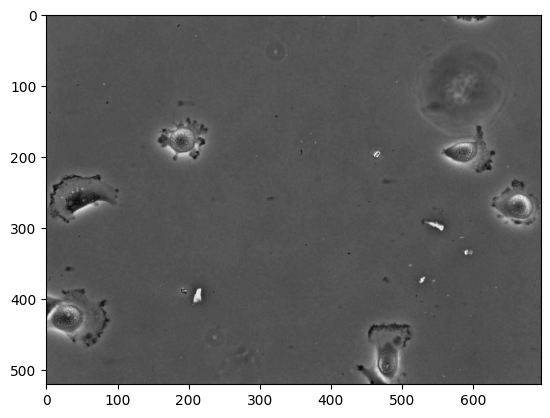

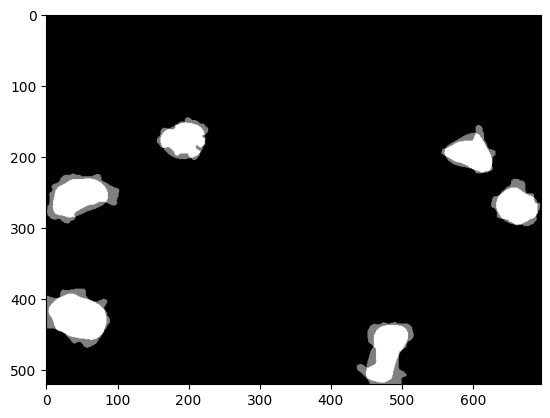

In [ ]:
# Prediccion del primer elemento
pred = red_cross(x_val[0:1,:,:,0])
print(pred.numpy().max())

plt.imshow(x_val[0,:,:,0], cmap="gray") #Imagen
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray")  #Anotación
plt.imshow(pred[0,:,:,0]>0.6, cmap="gray", alpha=0.5) #Prediccion
plt.show()

## Dice loss

In [ ]:
#Red_dice
preproc= get_preproc()
preproc_val = get_preproc_val()
red_dice = get_red_seg()
red_dice.summary()
model_dice = SegmentationModel(preproc, red_dice, preproc_val, dice=True)
model_dice.dice=True
model_dice.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
model_dice.fit(np.vstack([x_train, x_val]), batch_size=16, epochs=50, validation_split = 0.5,  verbose = 1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, None, None, 16)    1616      
                                                                 
 conv2d_7 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_8 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_9 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 16)    25616     
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

1.0


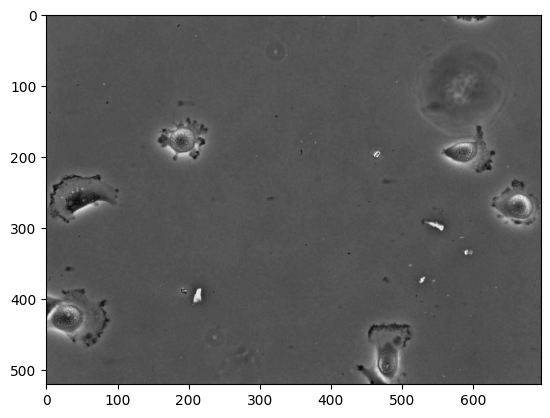

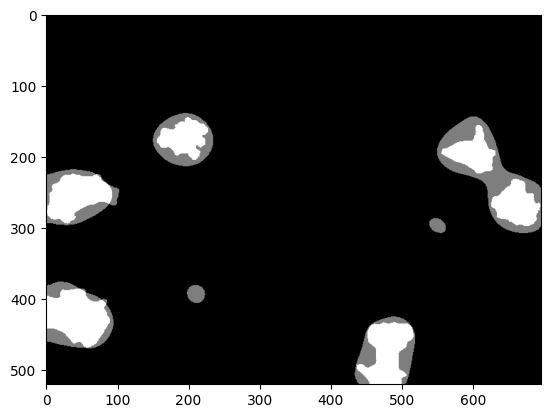

In [ ]:
# Prediccion del primer elemento
pred = red_dice(x_val[0:1,:,:,0])
print(pred.numpy().max())

plt.imshow(x_val[0,:,:,0], cmap="gray") #Imagen
plt.show()
plt.imshow(x_val[0,:,:,1], cmap="gray")  #Anotación
plt.imshow(pred[0,:,:,0]>0.6, cmap="gray", alpha=0.5) #Prediccion
plt.show()

Se puede notar como ante las mismas condiciones, le resulta mucho mas complicado encontrar un mínimo de la loss utilizando ***dice***, respecto a la ***binary cross-entropy***. Para mejorar el modelo que utiliza el dice como función de loss, se podría agragar batch normalization, o ir variando el learning rate a medida que se avanza en la epochs. Ésto se pondrá a prueba directamente en la U-net.

#Red U-NET

La idea de la U-net es un autoencoder (para poder aumentar el campo perceptual), con conexiones nivel a nivel concatenadas. Al comienzo se hará max-polling y luego un up-sampling para lograr tener el mismo tamaño de entrada. finalmente se le aplicara una capa softmax, ya que se quiere distinguir entre "celula" y "no celula".

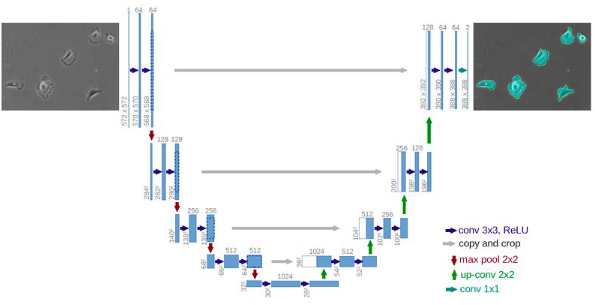

Al hacer max-pooling y despues up-sampling, puedo tener un problema con las imparidades. Por lo tanto se optó por hacer un preprocesamiento (crops de 512) para los datos de validación.

In [ ]:
img_shape = (512, 512, 1)

# m=input, dim=cantidad de filtros, acti = función de activación, bn= batch norm, res = conexiones residuales, do=dropout
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)	# Kernel de tamaño 3
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n	# Concatena (skip conection)

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)	# Mis nuevas dimensiones son inc*dim
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)	# Stride de 2, doble de grande
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

La red planteada cuenta con drop out, pero no con batch normalization. La recursividad se debe a plantear sucesivos max-pooling y up-sampling (o conv2Dtransponse, lo cual es análogo). A su vez, aparte de utilizar el concepto de skip conection,  se podrían utilizar conexiones residuales en cada uno de los bloques, lo cual permitiría solucionar el problema de la propagación del gradiente en redes neuronales profundas.

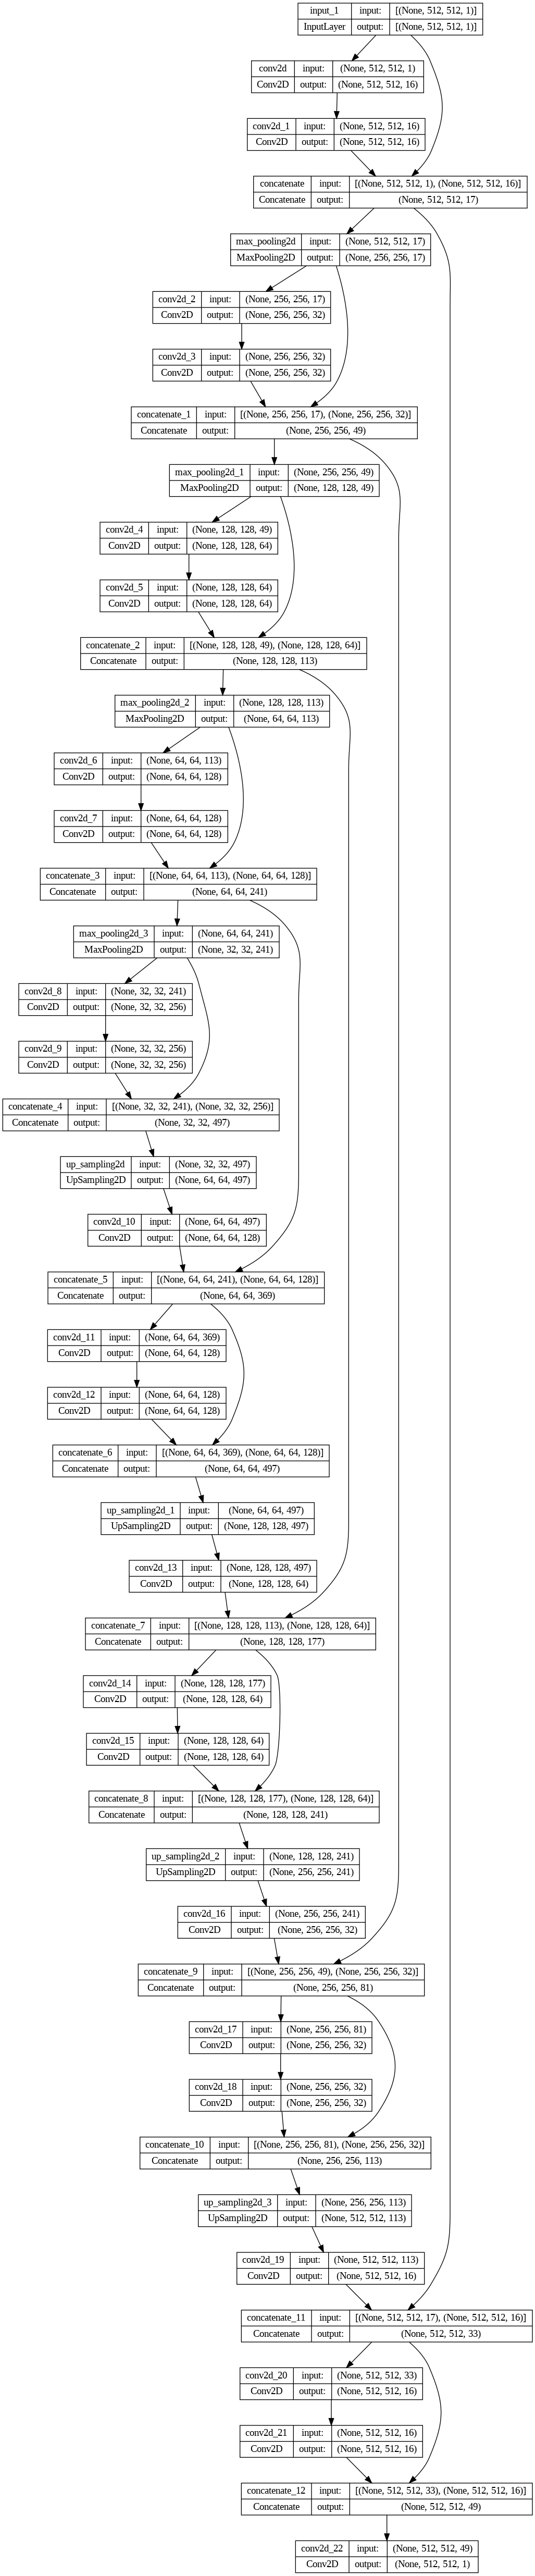

In [ ]:
plot_model(red_unet, show_shapes=True)

Se puede observar como el conexionado es correcto, ya que coincide con el de la imagen de la U-net mostrada previamente.

##Binary cross-entropy loss

In [ ]:
preproc_unet= get_preproc()
preproc_unet_val= get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet_bin = SegmentationModel(preproc_unet, red_unet,preproc_unet_val,dice=False)
red_unet.summary()
model_unet_bin.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
model_unet_bin.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, verbose = 1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 512, 512, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_46[0][0]']              
                                )                                                           

0.97384566


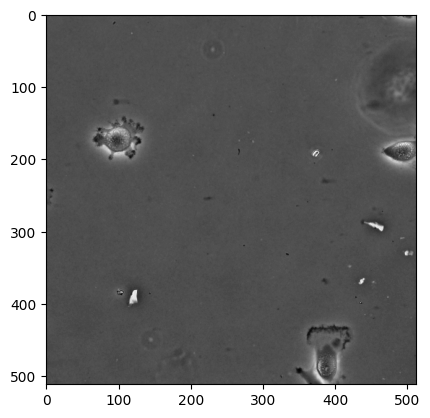

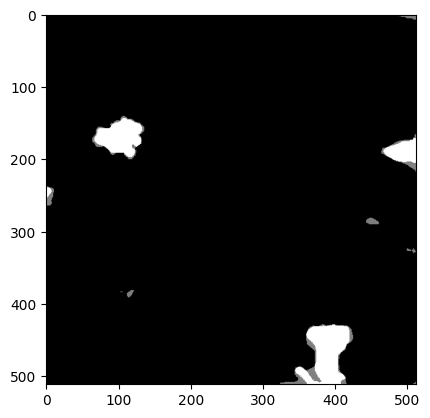

In [ ]:
# Prediccion del primer elemento
aux = preproc_unet_val(x_val[0:1,:,:,:])
pred = red_unet(aux[0:1,:,:,0])
print(pred.numpy().max())

plt.imshow(aux[0,:,:,0], cmap="gray")
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray")
plt.imshow(pred[0,:,:,0]>0.4, cmap="gray", alpha = 0.5)
plt.show()

In [ ]:
print('Dice: ',np.array(dice_coef(aux[0,:,:,1], pred[0,:,:,0])).item())

Dice:  0.7172564268112183


##Dice loss

In [ ]:
preproc_unet_dice= get_preproc()
preproc_unet_val_dice= get_preproc_val()
red_unet_dice = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet_dice = SegmentationModel(preproc_unet_dice, red_unet_dice, preproc_unet_val_dice, dice=True)
red_unet_dice.summary()
model_unet_dice.compile(optimizer= tf.keras.optimizers.Adam(1e-4))
model_unet_dice.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, verbose = 1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 512, 512, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_47 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_46[0][0]']              
                                )                                                           

1.0


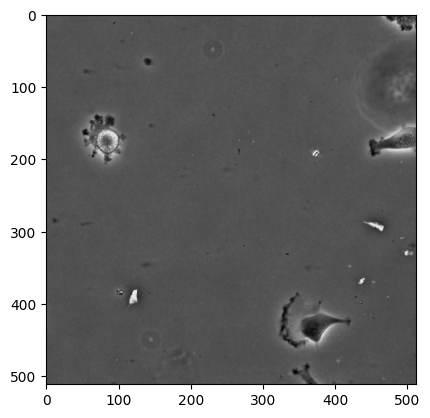

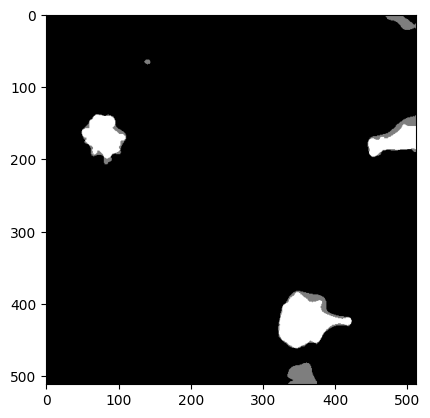

In [ ]:
# Prediccion del primer elemento
aux = preproc_unet_val_dice(x_val[0:1,:,:,:])
pred = red_unet_dice(aux[0:1,:,:,0])
print(pred.numpy().max())

plt.imshow(aux[0,:,:,0], cmap="gray") #Imagen
plt.show()
plt.imshow(aux[0,:,:,1], cmap="gray")  #Anotación
plt.imshow(pred[0,:,:,0]>0.6, cmap="gray", alpha=0.5) #Prediccion
plt.show()

In [ ]:
print('Dice: ',np.array(dice_coef(aux[0,:,:,1], pred[0,:,:,0])).item())

Dice:  0.8902915120124817


In [ ]:
dice=0
for i in range(len(x_val)):
  aux_dice = preproc_unet_val_dice(x_val[i:i+1,:,:,:])
  pred_dice = red_unet_dice(aux_dice[0:1,:,:,0])
  dice = dice + np.array(dice_coef(aux_dice[0,:,:,1], pred_dice[0,:,:,0])).item()
dice=dice/len(x_val)
print('Dice promedio: ', dice)

Dice promedio:  0.8212033606093863


A pesar de que claramente la loss es mucho mayor en el caso de utilizar el **dice** como loss function, respecto a utilizar la **binary cross-entropy** como loss function, se puede ver (tanto numéricamente, como en la similitud de las imágenes) que el coficiente de dice es mucho menor en el caso de utilizar la binary cross-entropy como función de loss.

**Por lo tanto se puede concluir que si bien la loss function es mayor, el coeficiente de dice es mayor utilizando dice como función de costo.**

##Dice mejorado

Se optó por variar algunos parámetros con el objetivo de **mejorar el coeficiente de dice**:
*   **Learning rate**: dado que a veces se quedaba estancado en un número, sue mínimamente veriando el learning rate hasta hallar un valor óptimo. Un learning rate mayor a $10^{-3}$ provocaba un estancamiento con una loss de 0.9, mientras que un learning rate menor a $10^{-5}$ provocaba una muy lenta convergencia (tan lenta que con 50 epochs apenas cambiaba).
*   **Batch size**: Éste debía ser menor o igual a 8, ya que sino no se podía ejecutar el código por falta de recursos. Por lo tanto no se lo modificó.
*   **Numero de channels**: ocurria algo similar que con el batchsize. Por lo que se decidió no modificarlo.
*   **Batch normalization**: debido a que a veces la loss se estancaba en ciertos valores, la utilización de batch normalization ayudaría a evitarlo
*   **Drop out**: si bien esta contrindicado utilizar batch normalization y drop out, debido a que había una gran diferencia entre la loss de train y validación, se utilizó un drop out de 0.4 para intentar que entrenasen todas las neuronas.
*   **Residual conection**: se continuó utilizando, ya que permite solucionar el problema de la propagación del gradiente.







In [ ]:
preproc_unet_dice_plus = get_preproc()
preproc_unet_val_dice_plus = get_preproc_val()
red_unet_dice_plus = UNet(
    img_shape,
    start_ch = 16,
    dropout = 0.4,
    batchnorm= True,
    residual = True
)
model_unet_dice_plus = SegmentationModel(preproc_unet_dice_plus, red_unet_dice_plus, preproc_unet_val_dice_plus, dice=True)
red_unet_dice_plus.summary()
model_unet_dice_plus.compile(optimizer= tf.keras.optimizers.Adam(0.5e-3))
model_unet_dice_plus.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, verbose = 1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 512, 512, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 16  64         ['conv2d_23[0][0]']              
 ormalization)                  )                                                           

1.0


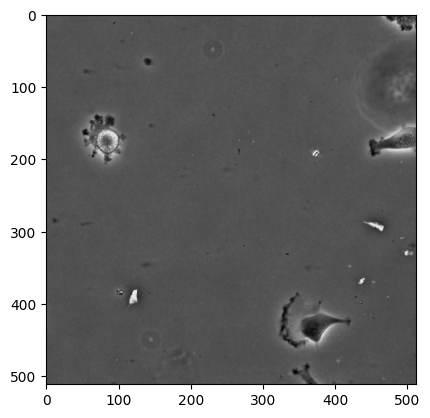

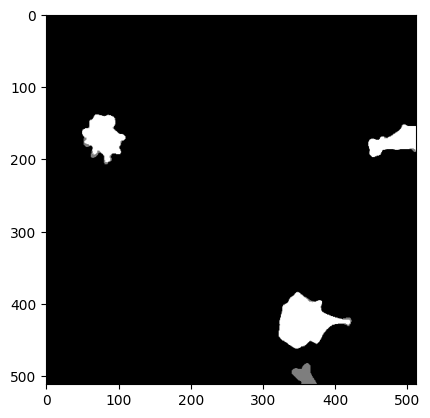

In [ ]:
# Prediccion del primer elemento
aux_plus = preproc_unet_val_dice_plus(x_val[0:1,:,:,:])
pred_plus = red_unet_dice_plus(aux_plus[0:1,:,:,0])
print(pred_plus.numpy().max())

plt.imshow(aux_plus[0,:,:,0], cmap="gray") #Imagen
plt.show()
plt.imshow(aux_plus[0,:,:,1], cmap="gray")  #Anotación
plt.imshow(pred_plus[0,:,:,0]>0.6, cmap="gray", alpha=0.5) #Prediccion
plt.show()

In [ ]:
print('Dice mejorado: ',np.array(dice_coef(aux_plus[0,:,:,1], pred_plus[0,:,:,0])).item())

Dice mejorado:  0.9391739964485168


In [ ]:
dice=0
for i in range(len(x_val)):
  aux_plus = preproc_unet_val_dice_plus(x_val[i:i+1,:,:,:])
  pred_plus = red_unet_dice_plus(aux_plus[0:1,:,:,0])
  dice = dice + np.array(dice_coef(aux_plus[0,:,:,1], pred_plus[0,:,:,0])).item()
dice=dice/len(x_val)
print('Dice mejorado promedio: ', dice)

Dice mejorado promedio:  0.8883318973624188


Se puede notar que el coeficiente de dice mejoró mucho respecto a los modelos anteriores (tanto en la primera imagen de manera individual como en el promedio de todos los coeficientes de dice), tanto numéricamente como observando la imagen. Por lo tanto se puede concluir que la mejora realizada fue exitosa.

## Dice mejorado 2

Se agregó una segunda capa convolucional con conexión residual, con el objetivo de que se fortaleciera la propagación de la información en la red y se permitiera una representación más compleja de las características en cada nivel de la U-Net.

In [ ]:
def level_block2(m, dim, depth, inc, acti, do, bn, mp, up, res):
  if depth > 0:
    n = conv_block(m, dim, acti, bn, res)
    m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
    m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)	# Mis nuevas dimensiones son inc*dim
    if up:
      m = UpSampling2D()(m)
      m = Conv2D(dim, 2, activation=acti, padding='same')(m)
    else:
      m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)	# Stride de 2, doble de grande
    n = Concatenate()([n, m])
    m = conv_block(n, dim, acti, bn, res)
    m = conv_block(m, dim, acti, bn, res)  # Agregar otra capa convolucional con conexión residual
  else:
    m = conv_block(m, dim, acti, bn, res, do)
  return m

def UNet2(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block2(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

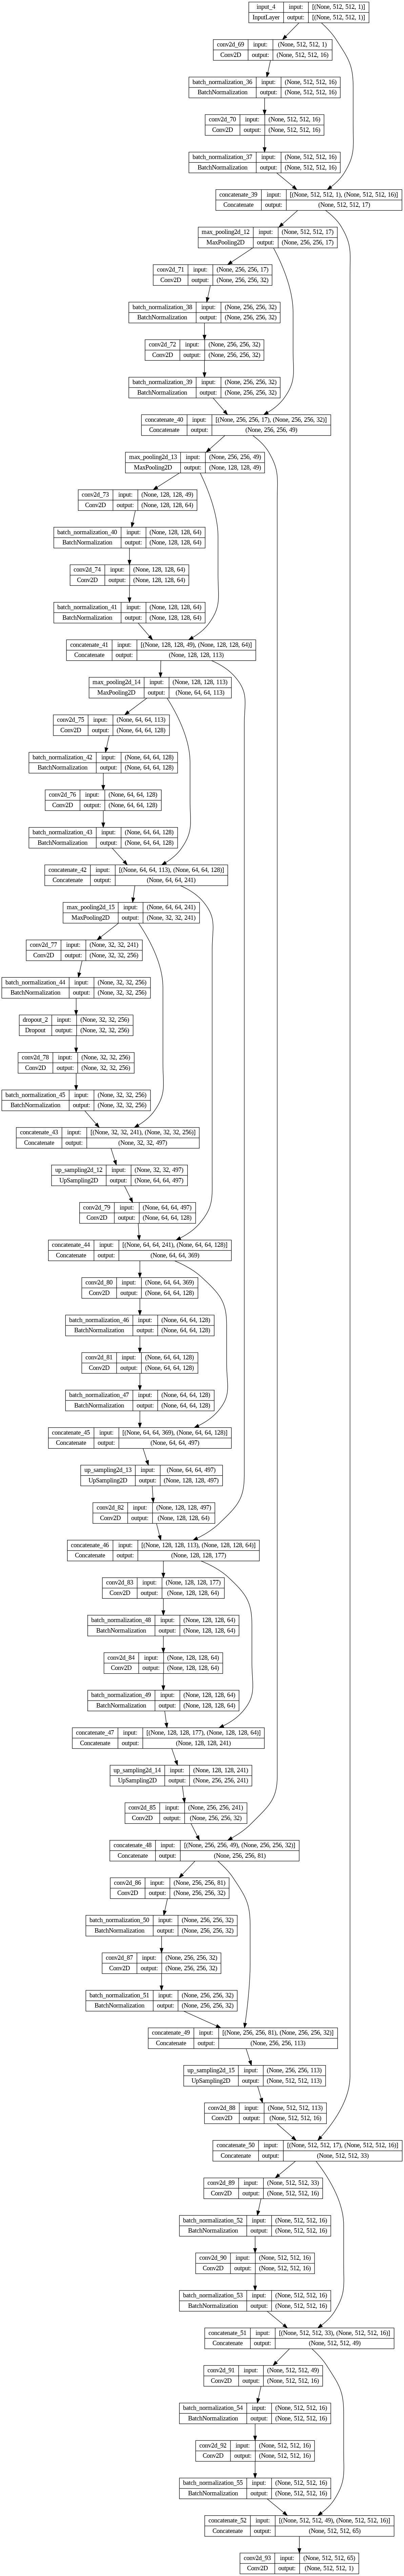

In [ ]:
plot_model(red_unet_dice_plus2, show_shapes=True)

In [ ]:
preproc_unet_dice_plus2 = get_preproc()
preproc_unet_val_dice_plus2 = get_preproc_val()
red_unet_dice_plus2 = UNet2(
    img_shape,
    start_ch = 16,
    dropout = 0.4,
    batchnorm= True,
    residual = True
)
model_unet_dice_plus2 = SegmentationModel(preproc_unet_dice_plus2, red_unet_dice_plus2, preproc_unet_val_dice_plus2, dice=True)
red_unet_dice_plus2.summary()
model_unet_dice_plus2.compile(optimizer= tf.keras.optimizers.Adam(0.5e-3))
model_unet_dice_plus2.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=50, validation_split = 0.5, verbose = 1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 512, 512, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 512, 512, 16  64         ['conv2d_69[0][0]']              
 ormalization)                  )                                                           

1.0


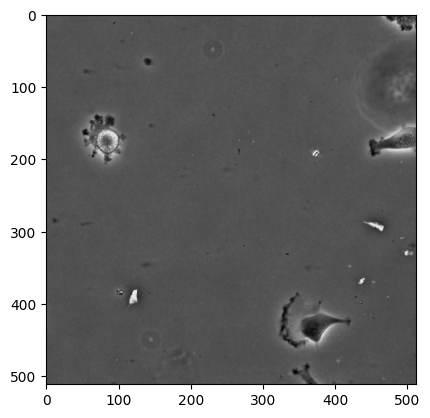

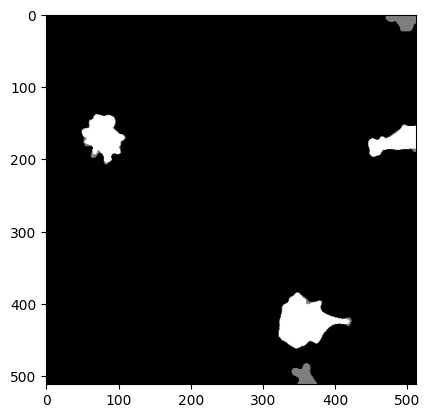

In [ ]:
# Prediccion del primer elemento
aux_plus2 = preproc_unet_val_dice_plus2(x_val[0:1,:,:,:])
pred_plus2 = red_unet_dice_plus2(aux_plus2[0:1,:,:,0])
print(pred_plus2.numpy().max())

plt.imshow(aux_plus2[0,:,:,0], cmap="gray") #Imagen
plt.show()
plt.imshow(aux_plus2[0,:,:,1], cmap="gray")  #Anotación
plt.imshow(pred_plus2[0,:,:,0]>0.6, cmap="gray", alpha=0.5) #Prediccion
plt.show()

In [ ]:
print('Dice mejorado: ',np.array(dice_coef(aux_plus2[0,:,:,1], pred_plus2[0,:,:,0])).item())

Dice mejorado:  0.8958739042282104


In [ ]:
dice=0
for i in range(len(x_val)):
  aux_plus2 = preproc_unet_val_dice_plus2(x_val[i:i+1,:,:,:])
  pred_plus2 = red_unet_dice_plus2(aux_plus2[0:1,:,:,0])
  dice = dice + np.array(dice_coef(aux_plus2[0,:,:,1], pred_plus2[0,:,:,0])).item()
dice=dice/len(x_val)
print('Dice mejorado promedio: ', dice)

Dice mejorado promedio:  0.8924571327541185


Si bien el coeficiente de dice empeoró minimamente en lqa primera imgaen, su promedio tuvo una mejora (no tan significativa como la primera mejora, pero una mejora en fin). Por lo tanto se puede concluir que también la segunda mejora añadida fue exitosa y permitió elevar el coeficiente de dice.